In [105]:
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.metrics import DistanceMetric
import numpy as np
import torch
import random
import matplotlib.pyplot as plt
from umap.umap_ import UMAP
import pandas as pd
from matplotlib.patches import Patch





**Data Plotting**

Number of elements in feature list: 1002


/opt/venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Shape of reduced features list: (1002, 2)
Cluster 0 contains 285 elements
Cluster 1 contains 295 elements
Cluster 2 contains 418 elements
[0, 0, 0, 1, 0, 1, 2, 2, 0, 2, 1, 0, 2, 2, 2, 2, 1, 2, 0, 2, 2, 0, 1, 2, 0, 0, 2, 2, 0, 2, 0, 1, 0, 2, 0, 0, 0, 1, 1, 2, 2, 2, 0, 1, 2, 1, 2, 1, 2, 2, 1, 2, 0, 0, 2, 1, 2, 2, 0, 1, 2, 0, 1, 2, 1, 2, 0, 2, 2, 1, 2, 1, 1, 2, 2, 2, 1, 0, 1, 2, 0, 2, 2, 1, 0, 2, 2, 0, 0, 2, 2, 2, 0, 2, 1, 1, 1, 1, 2, 2, 0, -1, 1, 1, 2, 2, 1, 0, 1, 0, 1, 2, 2, 2, 2, 0, 1, 2, 1, 0, 2, 2, 2, 0, 1, 2, 2, 2, 1, 1, 1, 2, 0, 0, 1, 1, 2, 1, 1, 2, 1, 1, 0, 0, 1, 2, 1, 2, 1, 1, 1, 2, 2, 0, 1, 1, 0, 0, 2, 2, 1, 1, 0, 2, 2, 0, 0, 0, 2, 0, 1, 1, 0, 2, 0, 1, 2, 2, 2, 2, 1, 0, 1, 2, 2, 2, 0, 2, 1, 0, 2, 1, 2, 2, 2, 0, 0, 0, 2, 2, 0, 2, 2, 2, 0, 0, 0, 0, 1, 2, 1, 2, 1, 0, 2, 1, 0, 2, 0, 1, 2, 0, 2, 2, 2, 1, 2, 2, 2, 2, 2, 0, 0, 1, 2, 1, 0, 2, 2, 1, 0, 0, 1, 0, 2, 1, 1, 2, 2, 0, 2, 0, 1, 2, 2, 2, 0, 0, 2, 2, 0, 2, 1, 1, 0, 2, 1, 1, 2, 1, 2, 2, 1, 2, 2, 0, 2, 1, 0, 2, 2, 2, 0, 2, 2, 1, 2,

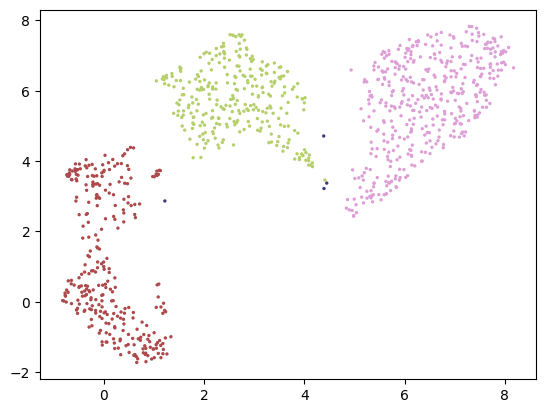

In [ ]:
feature_space = torch.load("/workspaces/dbm25/data/extracted_features.pt")

label = "brain_menin"

feature_list = [elem["layer3"].numpy() for elem in feature_space if elem["class"] == label]
print("Number of elements in feature list:", len(feature_list))

# Configurazione di UMAP
reducer = UMAP(
    n_components=2,     
    n_neighbors=50,      
    min_dist=0.2,        
    metric='euclidean',  
    random_state=42      
)

embedded_data = reducer.fit_transform(feature_list)


reduced_features_list = np.array(embedded_data)
print("Shape of reduced features list:", reduced_features_list.shape)
#max_euclidean_dist = max([np.linalg.norm(a - b) for a in reduced_features_list for b in reduced_features_list]) 
#print("Max Euclidean distance:", max_euclidean_dist) # 11.838603
#distance = DistanceMetric.get_metric('euclidean')
#print(distance.pairwise(reduced_features_list[0].reshape(1,-1), reduced_features_list[1].reshape(1,-1))) 


clustering = DBSCAN(eps=0.5, min_samples=5).fit(embedded_data)
labels = clustering.labels_


n_cluster = len(set(labels)) - (1 if -1 in labels else 0)
for cluster in set(labels):
    if cluster != -1:
        print("Cluster", cluster, "contains", np.sum(labels == cluster), "elements")
print(labels.tolist())
print(n_cluster)

df = pd.DataFrame(embedded_data, columns=["x", "y"])
df["label"] = [label for label in labels]

#plt.scatter(df.x, df.y, alpha=0.6, s=2, c="grey")
plt.scatter(df.x, df.y, c=df.label.astype(int), cmap="tab20b")